In [1]:
import numpy as np
from math import pi, sqrt, tanh
from matplotlib import pyplot
from scipy.linalg import block_diag
from ipywidgets import interact

Imposing boundary condition at left of sc u_K=u_K' and v_K= v_K'

In [118]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=4*hwc #1e2*meV
mu_sc=5*hwc #1e2*meV
D_sc=0.5*hwc #10*meV
nu=1.2 #sqrt(2)+0.1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(-1,1,50)*4/lB


Ls=8*lB
Lx=8*lB
Nx=200
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(np.diag(kx) , sigma1)
HeB= -2*vF*elec*B* np.kron(np.real(y1(k1-k2)), sigma2)
HeBT= -2*vF*elec*B* np.kron(np.real(y1(k2-k1)), sigma2)

Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)
HxmT= np.kron( y0s(k2-k1) , m_sc*sigma3)
Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

Hd= 1j*np.kron(D_sc*y0s(k1+k2),sigma0)
dmat=np.array([[0.,1.],[0.,0.]])
Hd_mat=np.kron(dmat,Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()


Vn=np.zeros((4*Nx,4*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((4*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= np.kron(hbar*vF*ky*np.eye(Nx), sigma2)

    H1 = Hx +Hy + HeB + Hxm + Hef  
    H1T = -Hx +Hy + (HeBT + HxmT + HefT).conj()

    H_t=block_diag(H1,-H1T)+Hd_mat

    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)

print("Done!")

Done!


In [119]:
def wf_real_space(ev,k,x,Lx):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1]) #*np.sqrt(x[1]-x[0]),
    return np.dot(np.exp(1j*kt*xt),ev[0:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev[1:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0])


def plot_wf(i_band=Nx,iwf=int(3*len(ky_sw)/4)):
# iwf=0
    pyplot.figure()
    pyplot.subplot(2,1,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-1,1)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*10*lB
    wfp_a,wfp_b,wfh_a,wfh_b=wf_real_space(np.reshape(Vn[:,i_band,:],[4*Nx,len(ky_sw)]),kx,x0,Lx)
#     pyplot.figure()
    pyplot.subplot(2,1,2)
    pyplot.plot(x0/lB,np.abs(wfp_a[:,iwf])**2,label=r'$eA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfp_b[:,iwf])**2,label=r'$eB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfh_a[:,iwf])**2,label=r'$hA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfh_b[:,iwf])**2,label=r'$hB\downarrow$')
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.legend()
#     pyplot.ylim(0,8e7)
    pyplot.show()

In [120]:
interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(2*Nx-int(nu**2)-2,2*Nx+int(nu**2)+2));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(397, 398, 399, 400, 401, 402), value=397), IntSl…

In [ ]:
pyplot.figure()
# pyplot.plot(ky_sw/1e9,En.T/meV)
pyplot.plot(ky_sw*lB,En.T/hwc,'b')
pyplot.ylabel("Energy(meV)")
# pyplot.xlabel("ky(1/nm)")
pyplot.xlabel("X(l)")
pyplot.ylim(-1,1)
# pyplot.xlim(-7.5,7.5)
pyplot.grid()
pyplot.show()

Without imposing boundary condition

In [4]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=8*hwc #1e2*meV
D_sc=.5*hwc #10*meV
nu=0.2#sqrt(2)+0.1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(-1,1,140)*7.5/lB


Lx=8*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx)-pi*Nx/(2*Lx)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx)-pi*Nx/(2*Lx)

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= (-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx**2 /6.0
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = (-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx/4.0
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*(-1+np.exp(1j*k*Lx) )/(k*2*Lx)
        c[ ~ np.isfinite( c )] = 0.5
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(sigma3,np.kron(np.diag(kx) , sigma1))
HeB= -vF*elec*B* np.kron(sigma0,np.kron(y1(k1-k2), sigma2))
HeBT= -vF*elec*B* np.kron(sigma0,np.kron(y1(k2-k1), sigma2))


Hxm= np.kron(sigma0,np.kron( y0(k2-k1) , m_sc*sigma3))
HxmT= np.kron(sigma0,np.kron( y0(k1-k2) , m_sc*sigma3))
Hef= -np.kron(sigma0,np.kron( mu_n*y0(k1-k2) + mu_sc*y0(k2-k1), sigma0 ))
HefT= -np.kron(sigma0,np.kron( mu_n*y0(k2-k1) + mu_sc*y0(k1-k2), sigma0 ))
dmat= np.kron(np.array([[0.,1.0],[0.,0.]]),sigma1)
Hd= D_sc*np.kron(dmat,np.kron(y0(k2-k1) , sigma0))
Hd_mat= Hd+np.transpose(Hd).conj()


En=np.zeros((8*Nx,len(ky_sw)))
Vn=np.zeros((8*Nx,8*Nx,len(ky_sw)), dtype=np.complex64)
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= np.kron(sigma0,np.kron(hbar*vF*ky*np.eye(Nx), sigma2))
    H1 = Hx +Hy + HeB + Hxm + Hef 
    H1T = -Hx +Hy + (HeBT + HxmT + HefT).conj() # note -Hy gives intravalley
    H_t=block_diag(H1,-H1T)+Hd_mat
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
    
print("Done!")

Done!


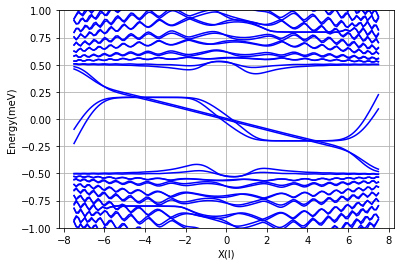

In [5]:
pyplot.figure()
# pyplot.plot(ky_sw/1e9,En.T/meV)
pyplot.plot(ky_sw*lB,En.T/hwc,'b')
pyplot.ylabel("Energy(meV)")
# pyplot.xlabel("ky(1/nm)")
pyplot.xlabel("X(l)")
pyplot.ylim(-1,1)
# pyplot.xlim(-7.5,7.5)
pyplot.grid()
pyplot.show()

In [137]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:4*Nx,:]
    ev_h= ev[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])


def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    pyplot.figure(figsize=(10,5))
    pyplot.subplot(2,2,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-1,1)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*10*lB
    wfp_uA,wfp_uB, wfp_dA,wfp_dB,\
    wfh_uA,wfh_uB, wfh_dA,wfh_dB =wf_real_space(np.reshape(Vn[:,i_band,:],[8*Nx,len(ky_sw)]),kx,x0,Ls)
#     pyplot.figure()
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.subplot(2,2,3)
    pyplot.plot(x0/lB,np.abs(wfp_uA[:,iwf])**2,label=r'$eA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfp_uB[:,iwf])**2,label=r'$eB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfh_dA[:,iwf])**2,label=r'$hA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfh_dB[:,iwf])**2,label=r'$hB\downarrow$')
    pyplot.legend()
    pyplot.subplot(2,2,4)
    pyplot.plot(x0/lB,np.abs(wfp_dA[:,iwf])**2,label=r'$eA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfp_dB[:,iwf])**2,label=r'$eB\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfh_uA[:,iwf])**2,label=r'$hA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfh_uB[:,iwf])**2,label=r'$hB\uparrow$')
    pyplot.legend()
    pyplot.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(4*Nx-int(nu**2)-3,4*Nx+int(nu**2)+3));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(397, 398, 399, 400, 401, 402), value=397), IntSl…